Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, mean_squared_error,
    confusion_matrix, classification_report, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Load Dataset

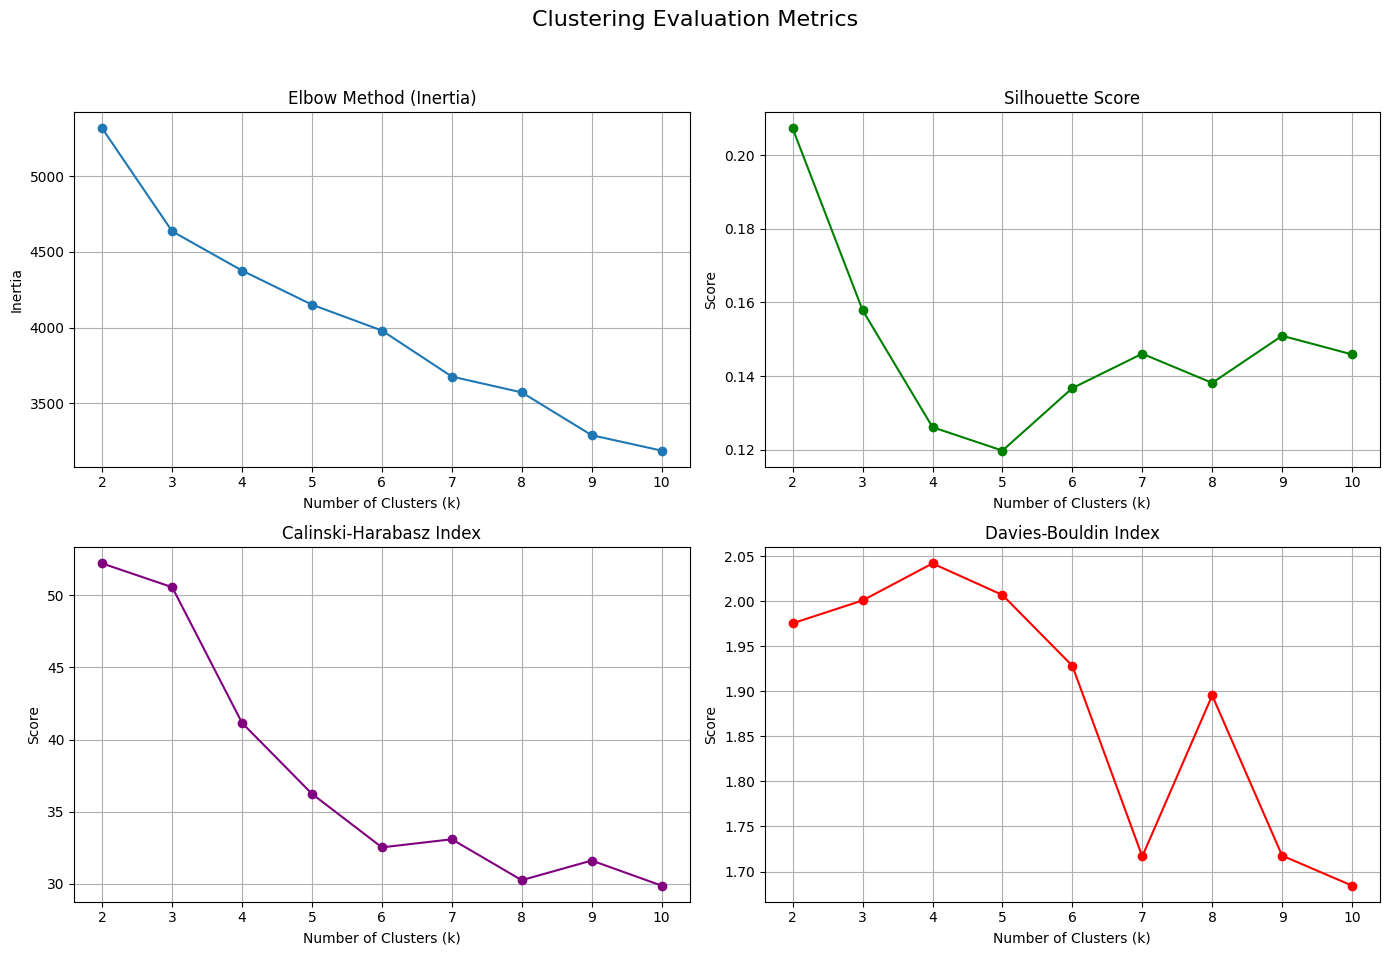

In [ ]:
input_path = r"C:\\Users\\mustafaerensoyhan\\Downloads\\breast cancer clustering classification\\breast_cancer_feature_eng.csv"
df = pd.read_csv(input_path)

if 'Cluster_Label' not in df.columns:
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

    # Prepare features
    drop_cols = ['Class', 'class_binary']
    drop_str = ['age', 'tumor-size', 'inv-nodes', 'menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat']
    X_tmp = df.drop(columns=drop_cols + drop_str)
    X_scaled_tmp = StandardScaler().fit_transform(X_tmp)

    # Evaluate for multiple k values
    k_range = range(2, 11)
    inertia, sil_scores, calinski_scores, db_scores = [], [], [], []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled_tmp)
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X_scaled_tmp, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled_tmp, labels))
        db_scores.append(davies_bouldin_score(X_scaled_tmp, labels))

    # Plot metrics
    plt.figure(figsize=(14, 10))

    # Elbow Method
    plt.subplot(2, 2, 1)
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method (Inertia)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)

    # Silhouette Score
    plt.subplot(2, 2, 2)
    plt.plot(k_range, sil_scores, marker='o', color='green')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')
    plt.grid(True)

    # Calinski-Harabasz Index
    plt.subplot(2, 2, 3)
    plt.plot(k_range, calinski_scores, marker='o', color='purple')
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')
    plt.grid(True)

    # Davies-Bouldin Index
    plt.subplot(2, 2, 4)
    plt.plot(k_range, db_scores, marker='o', color='red')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')
    plt.grid(True)

    plt.suptitle("Clustering Evaluation Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    df['Cluster_Label'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_scaled_tmp)


Step 3: Prepare features and targets

In [ ]:
X = df.drop(columns=[
    'Class', 'class_binary', 'Cluster_Label',
    'age', 'tumor-size', 'inv-nodes',
    'menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat'
])

y_cluster = df['Cluster_Label']
y_real = df['class_binary']


Step 4: Classification - Predict Cluster Labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cluster, test_size=0.2, stratify=y_cluster, random_state=42)

model_cluster = DecisionTreeClassifier(random_state=42)
model_cluster.fit(X_train, y_train)
y_pred_cluster = model_cluster.predict(X_test)
y_prob_cluster = model_cluster.predict_proba(X_test)[:, 1]

# Evaluation Metrics
acc_cluster = accuracy_score(y_test, y_pred_cluster)
roc_cluster = roc_auc_score(y_test, y_prob_cluster)
rmse_cluster = mean_squared_error(y_test, y_pred_cluster) ** 0.5  # ← Fixed here

print(f"Decision Tree (Cluster_Label Prediction)")
print(f"Accuracy: {acc_cluster:.4f}")
print(f"ROC AUC: {roc_cluster:.4f}")
print(f"RMSE: {rmse_cluster:.4f}")


Decision Tree (Cluster_Label Prediction)
Accuracy: 0.9655
ROC AUC: 0.9286
RMSE: 0.1857


Step 5: ROC Curves and Confusion Matrices for Train and Test, Clustering vs Real Class Evaluation Plotting as well as 2D Cluster Visualization of Clusters Using PCA

📊 Cluster Label Counts:
Cluster_Label
0    219
1     67
Name: count, dtype: int64


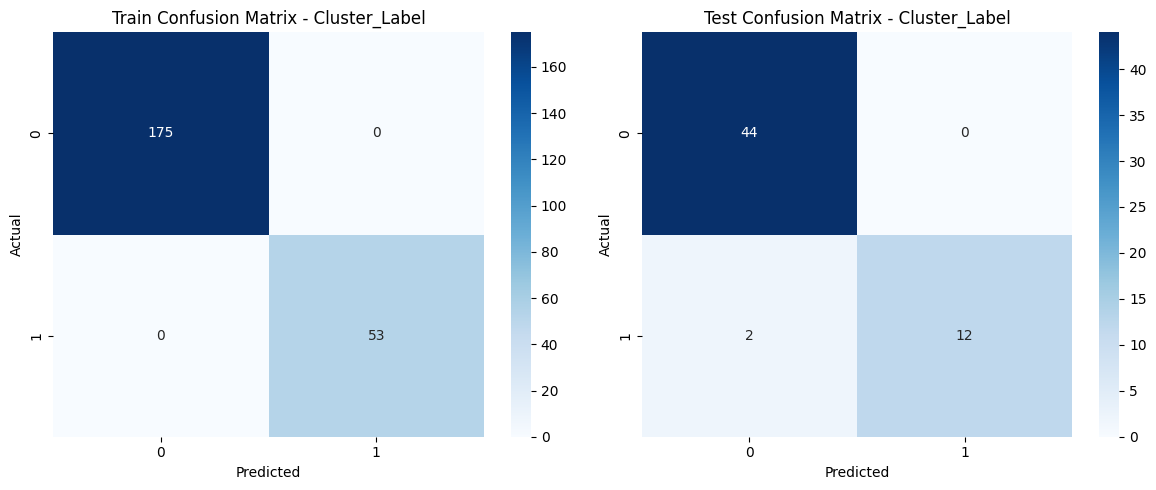

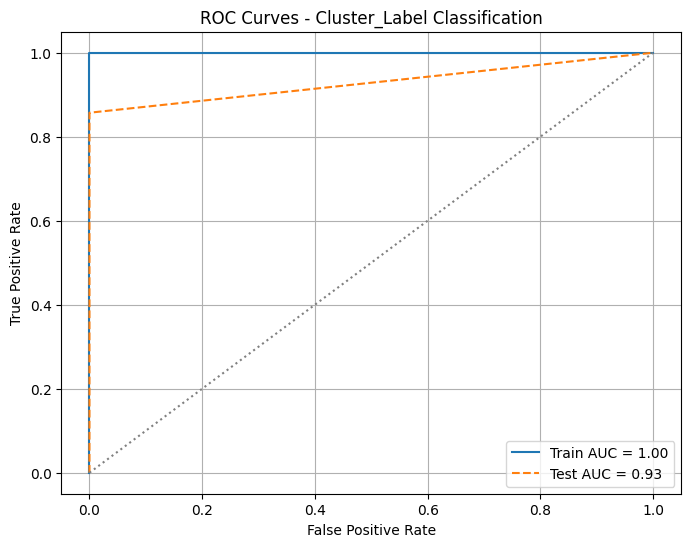

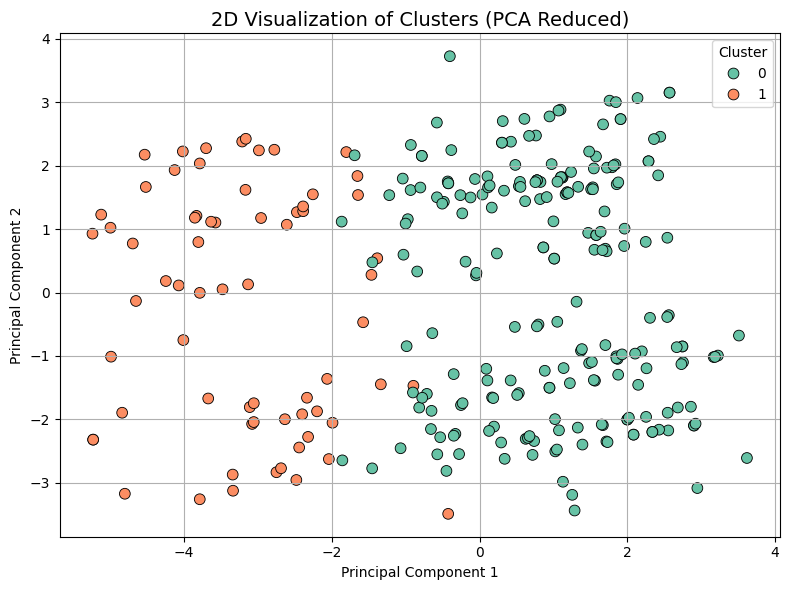

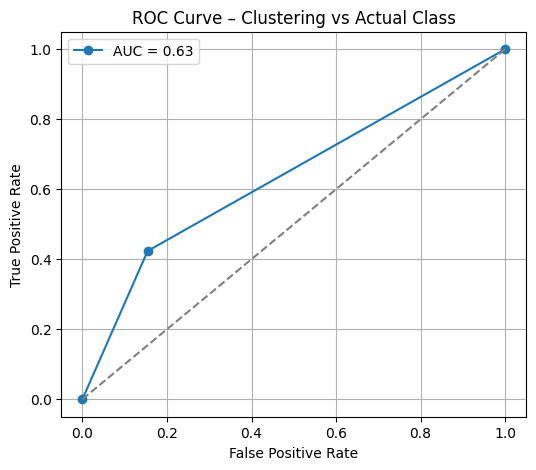

Classification Report (Clustering vs Real Class):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       201
           1       0.54      0.42      0.47        85

    accuracy                           0.72       286
   macro avg       0.66      0.63      0.64       286
weighted avg       0.71      0.72      0.71       286



In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.decomposition import PCA

# Print cluster distribution for reporting
print("📊 Cluster Label Counts:")
print(df['Cluster_Label'].value_counts())  # <-- NEW: adds missing info

# Train Predictions
y_train_pred = model_cluster.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_pred_cluster)

# Plot both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Train Confusion Matrix - Cluster_Label")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Test Confusion Matrix - Cluster_Label")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

y_train_prob = model_cluster.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_cluster)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Cluster_Label Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

X_scaled_full = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_full)

pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['Cluster_Label']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60, edgecolor='k')
plt.title("2D Visualization of Clusters (PCA Reduced)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

cluster_eval_labels = df['Cluster_Label']
real_class_labels = df['class_binary']

# Flip label orientation if needed
roc1 = roc_auc_score(real_class_labels, cluster_eval_labels)
roc2 = roc_auc_score(real_class_labels, 1 - cluster_eval_labels)
if roc2 > roc1:
    cluster_eval_labels = 1 - cluster_eval_labels
    print("Cluster labels flipped for better alignment with actual class.")

# ROC Curve - Cluster vs Real Class
fpr, tpr, _ = roc_curve(real_class_labels, cluster_eval_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='o', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Clustering vs Actual Class")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
print("Classification Report (Clustering vs Real Class):")
print(classification_report(real_class_labels, cluster_eval_labels))


Step 6: Predicting Real Class Labels (recurrence-events vs no-recurrence-events)

📌 Decision Tree (Real Class Prediction)
Accuracy: 0.6724
ROC AUC: 0.6521
RMSE: 0.5724


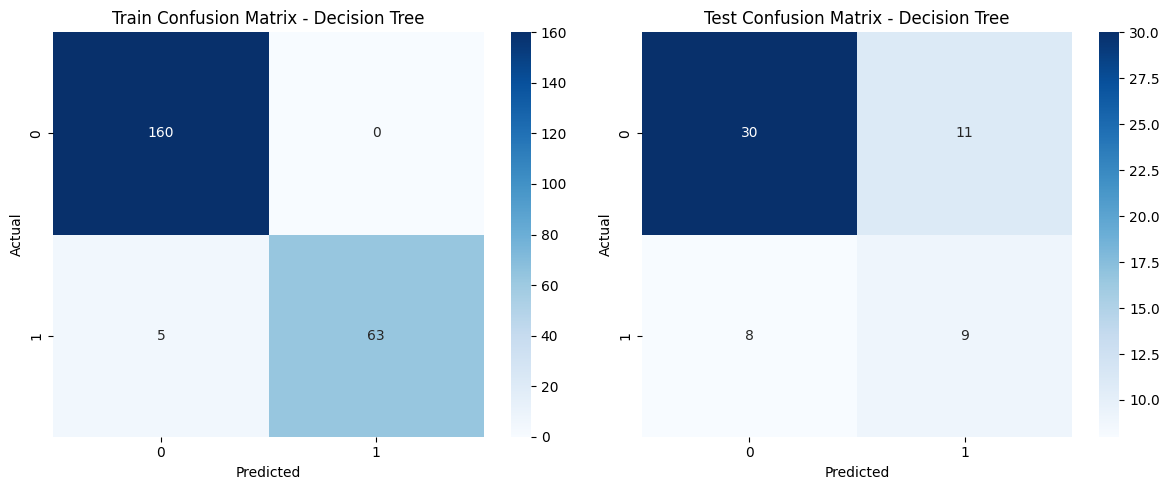

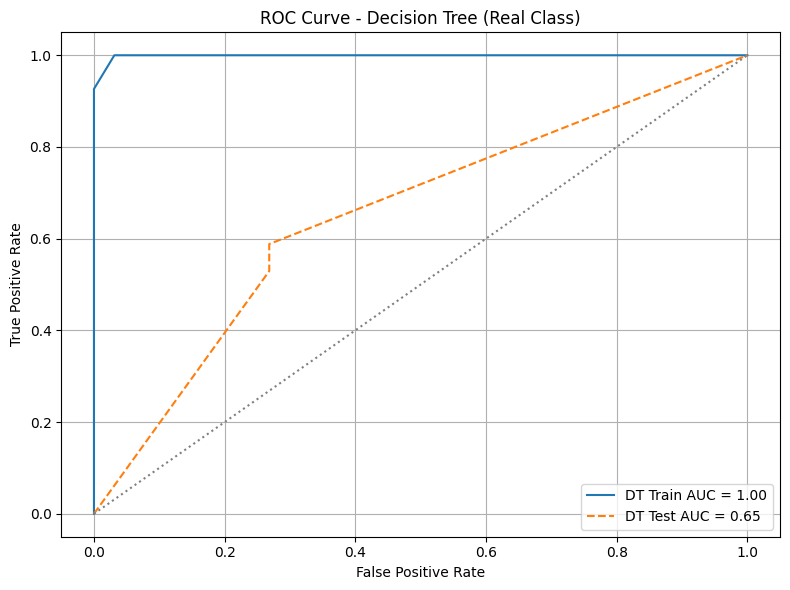

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        41
           1       0.45      0.53      0.49        17

    accuracy                           0.67        58
   macro avg       0.62      0.63      0.62        58
weighted avg       0.69      0.67      0.68        58


🌲 Random Forest (Real Class Prediction)
Accuracy: 0.6207
ROC AUC: 0.6141
RMSE: 0.6159


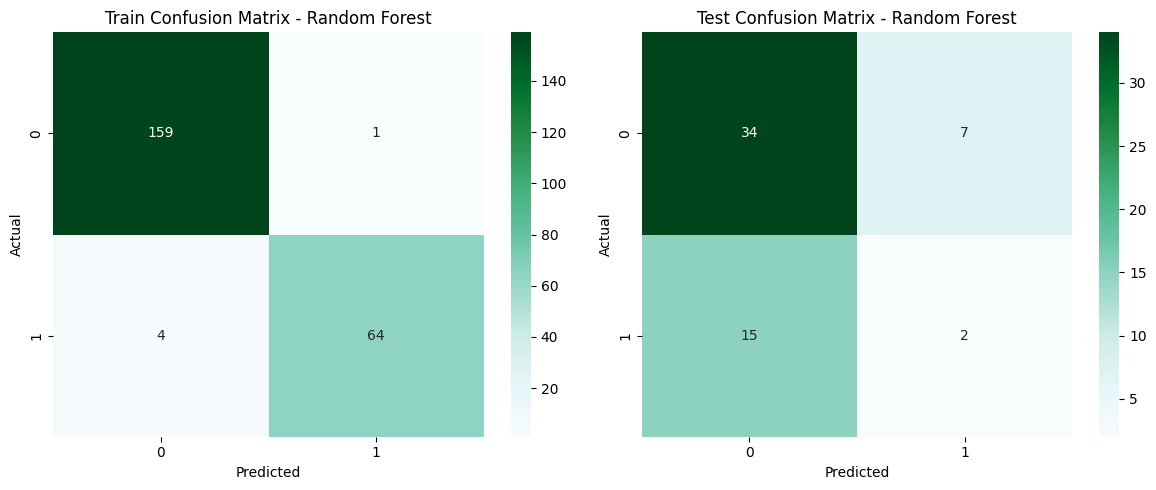

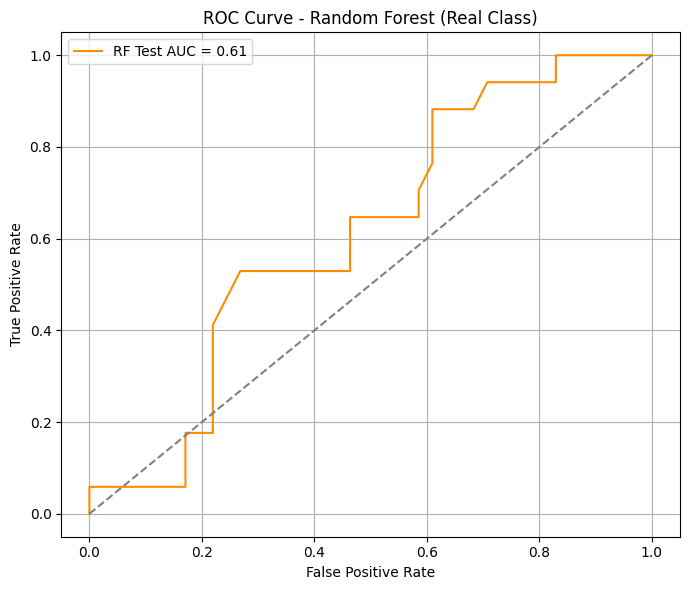

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.69      0.83      0.76        41
           1       0.22      0.12      0.15        17

    accuracy                           0.62        58
   macro avg       0.46      0.47      0.45        58
weighted avg       0.56      0.62      0.58        58



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train-test split
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X, y_real, test_size=0.2, stratify=y_real, random_state=42
)

### --- Decision Tree ---
model_real = DecisionTreeClassifier(random_state=42)
model_real.fit(X_train_real, y_train_real)
y_pred_real = model_real.predict(X_test_real)
y_prob_real = model_real.predict_proba(X_test_real)[:, 1]

acc_real = accuracy_score(y_test_real, y_pred_real)
roc_real = roc_auc_score(y_test_real, y_prob_real)
rmse_real = mean_squared_error(y_test_real, y_pred_real) ** 0.5

print("📌 Decision Tree (Real Class Prediction)")
print(f"Accuracy: {acc_real:.4f}")
print(f"ROC AUC: {roc_real:.4f}")
print(f"RMSE: {rmse_real:.4f}")

# Confusion Matrices for Decision Tree
y_train_pred_real = model_real.predict(X_train_real)
cm_train_real = confusion_matrix(y_train_real, y_train_pred_real)
cm_test_real = confusion_matrix(y_test_real, y_pred_real)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train_real, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Train Confusion Matrix - Decision Tree")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(cm_test_real, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Test Confusion Matrix - Decision Tree")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve for Decision Tree
y_train_prob_real = model_real.predict_proba(X_train_real)[:, 1]
fpr_train_real, tpr_train_real, _ = roc_curve(y_train_real, y_train_prob_real)
roc_auc_train_real = auc(fpr_train_real, tpr_train_real)
fpr_test_real, tpr_test_real, _ = roc_curve(y_test_real, y_prob_real)
roc_auc_test_real = auc(fpr_test_real, tpr_test_real)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_real, tpr_train_real, label=f'DT Train AUC = {roc_auc_train_real:.2f}')
plt.plot(fpr_test_real, tpr_test_real, label=f'DT Test AUC = {roc_auc_test_real:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Real Class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Classification Report (Decision Tree):")
print(classification_report(y_test_real, y_pred_real))


### --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_real, y_train_real)
y_pred_rf = rf_model.predict(X_test_real)
y_prob_rf = rf_model.predict_proba(X_test_real)[:, 1]

acc_rf = accuracy_score(y_test_real, y_pred_rf)
roc_rf = roc_auc_score(y_test_real, y_prob_rf)
rmse_rf = mean_squared_error(y_test_real, y_pred_rf) ** 0.5

print("\n🌲 Random Forest (Real Class Prediction)")
print(f"Accuracy: {acc_rf:.4f}")
print(f"ROC AUC: {roc_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

# Confusion Matrices for Random Forest
y_train_pred_rf = rf_model.predict(X_train_real)
cm_train_rf = confusion_matrix(y_train_real, y_train_pred_rf)
cm_test_rf = confusion_matrix(y_test_real, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train_rf, annot=True, fmt="d", cmap="BuGn", ax=axes[0])
axes[0].set_title("Train Confusion Matrix - Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(cm_test_rf, annot=True, fmt="d", cmap="BuGn", ax=axes[1])
axes[1].set_title("Test Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_real, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF Test AUC = {roc_auc_rf:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Real Class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Classification Report (Random Forest):")
print(classification_report(y_test_real, y_pred_rf))


Step 7: Forecasting Unknown Class Labels (Simulated '?')

🔮 Forecasted Outputs for Unknown Class Rows:
     Predicted_Class
9                0.0
267              1.0
143              1.0
212              1.0
227              0.0
155              1.0
283              1.0
73               1.0
196              0.0
33               0.0


C:\Users\mustafaerensoyhan\AppData\Local\Temp\ipykernel_11656\2909362309.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_unknowns, palette='Set2')


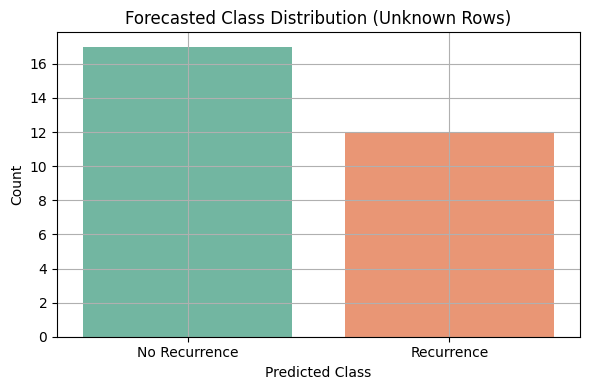

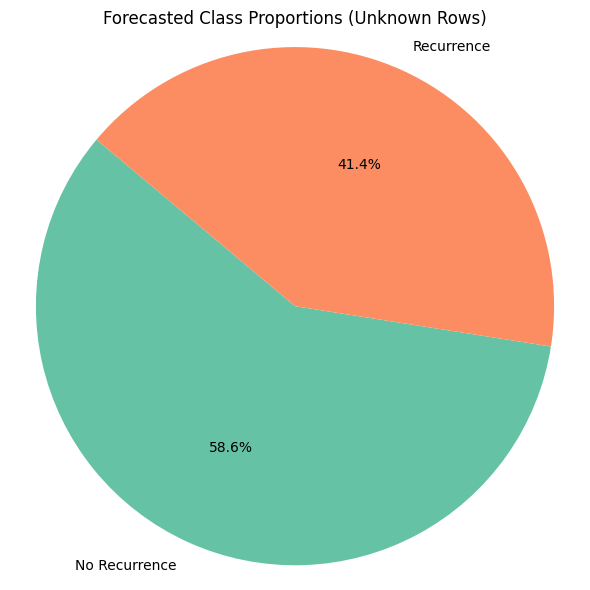

In [ ]:
# Make a copy to preserve original
df_forecast = df.copy()

# Simulate unknowns by setting 10% of class_binary to NaN
np.random.seed(42)
mask_indices = df_forecast.sample(frac=0.1).index
df_forecast.loc[mask_indices, 'class_binary'] = np.nan

# Split into known and unknown subsets
df_known = df_forecast[df_forecast['class_binary'].notna()]
df_unknown = df_forecast[df_forecast['class_binary'].isna()]

# Prepare features
X_known = df_known.drop(columns=[
    'Class', 'class_binary', 'Cluster_Label',
    'age', 'tumor-size', 'inv-nodes',
    'menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat'
])
y_known = df_known['class_binary']

X_unknown = df_unknown.drop(columns=[
    'Class', 'class_binary', 'Cluster_Label',
    'age', 'tumor-size', 'inv-nodes',
    'menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat'
])

# Train model on known data
model_forecast = DecisionTreeClassifier(random_state=42)
model_forecast.fit(X_known, y_known)

# Predict on unknown
predicted_unknowns = model_forecast.predict(X_unknown)

# Append predictions to DataFrame
df_forecast.loc[df_forecast['class_binary'].isna(), 'Predicted_Class'] = predicted_unknowns

# Show sample forecasted results
print("🔮 Forecasted Outputs for Unknown Class Rows:")
print(df_forecast.loc[mask_indices, ['Predicted_Class']].head(10))

plt.figure(figsize=(6, 4))
sns.countplot(x=predicted_unknowns, palette='Set2')
plt.title("Forecasted Class Distribution (Unknown Rows)")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['No Recurrence', 'Recurrence'])
plt.grid(True)
plt.tight_layout()
plt.show()

pred_counts = pd.Series(predicted_unknowns).value_counts().sort_index()
labels = ['No Recurrence', 'Recurrence']
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 6))
plt.pie(pred_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Forecasted Class Proportions (Unknown Rows)")
plt.axis('equal')
plt.tight_layout()
plt.show()


Step 8: Compare All Classification Models

📋 Model Performance Comparison (All Models)
                           Model  Accuracy   ROC AUC      RMSE
0  Decision Tree - Cluster_Label  0.965517  0.928571  0.185695
1     Decision Tree - Real Class  0.672414  0.652080  0.572351
2     Random Forest - Real Class  0.620690  0.614060  0.615882


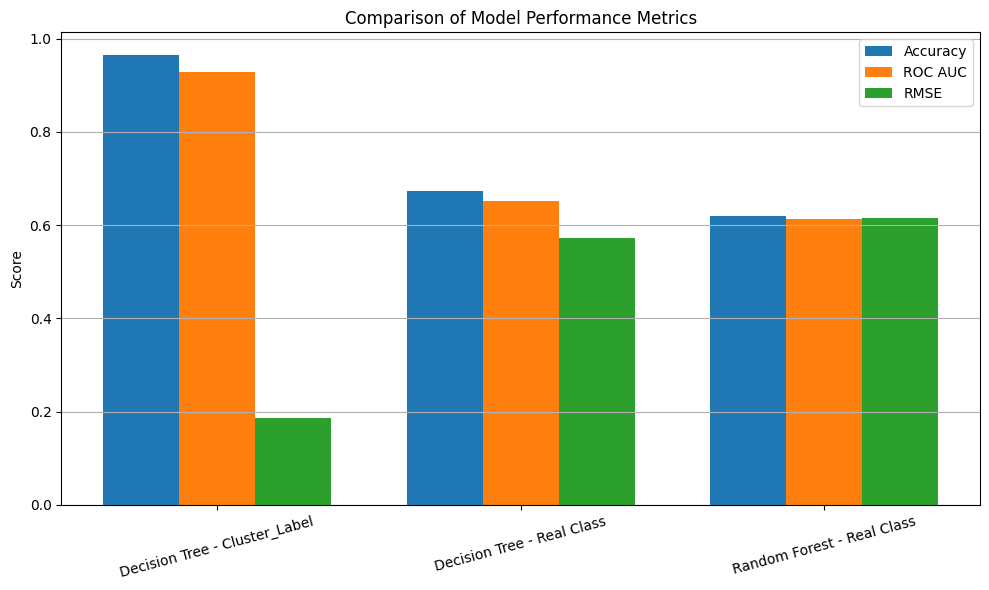

In [ ]:
model_names = [
    'Decision Tree - Cluster_Label',
    'Decision Tree - Real Class',
    'Random Forest - Real Class'
]
accuracy = [acc_cluster, acc_real, acc_rf]
roc_auc = [roc_cluster, roc_real, roc_rf]
rmse = [rmse_cluster, rmse_real, rmse_rf]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'ROC AUC': roc_auc,
    'RMSE': rmse
})

print("📋 Model Performance Comparison (All Models)")
print(comparison_df)

plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
bar_width = 0.25

plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x, roc_auc, width=bar_width, label='ROC AUC')
plt.bar(x + bar_width, rmse, width=bar_width, label='RMSE')

plt.xticks(x, model_names, rotation=15)
plt.ylabel("Score")
plt.title("Comparison of Model Performance Metrics")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
